In [38]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

import torch
from torch import nn

import os
import sys
import glob
import pickle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
SEED = 52
torch.manual_seed(SEED)

# Add parent dir to interpreter path
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

# Loading synthetic data

We will be loading simulated Hawkes data.

In [42]:
SYNTH_DATA_FILES = glob.glob('../data/simulated/*.pkl')
SYNTH_DATA_FILES.sort()
print("Available files:")
for s in SYNTH_DATA_FILES:
    print(s)

from utils.load_synth_data import process_loaded_sequences, one_hot_embedding

Available files:
../data/simulated/hawkes_sumxp_synthetic_exp_2d_20181210-002610.pkl
../data/simulated/hawkes_synthetic_exp_1d_20181205-142133.pkl
../data/simulated/hawkes_synthetic_exp_2d_20181206-160527.pkl
../data/simulated/hawkes_synthetic_exp_2d_20181207-220402.pkl
../data/simulated/hawkes_synthetic_exp_2d_20181209-211556.pkl


In [45]:
# SET THESE PARAMETERS
process_dim = 2
print("Process dimension: {}".format(process_dim))
chosen_data_file = SYNTH_DATA_FILES[3]
print("Data file: {}".format(chosen_data_file))

Process dimension: 2
Data file: ../data/simulated/hawkes_synthetic_exp_2d_20181207-220402.pkl


In [47]:
# Load data simulated using tick
print("Loading {}-dimensional Hawkes data.".format(process_dim))

with open(chosen_data_file, "rb") as f:
    loaded_hawkes_data = pickle.load(f)

print(loaded_hawkes_data.keys())

mu = loaded_hawkes_data['mu']
alpha = loaded_hawkes_data['alpha']
decay = loaded_hawkes_data['decay']
tmax = loaded_hawkes_data['tmax']
print("mu\t{:}".format(str(mu)))
print("alpha\t{:}".format(str(alpha)))
print("decay\t{:}".format(str(decay)))
print("tmax\t{:}".format(tmax))

seq_times, seq_types, seq_lengths = process_loaded_sequences(
    loaded_hawkes_data, process_dim, tmax)
print(seq_times.shape)

Loading 2-dimensional Hawkes data.
dict_keys(['mu', 'alpha', 'decay', 'tmax', 'timestamps', 'types', 'lengths'])
mu	[0.1 0.1]
alpha	[[0.1  0.01]
 [0.01 0.1 ]]
decay	1
tmax	3600
torch.Size([4000, 921])


# Neural network

We are going for a recurrent neural structure that can learn from previous events. The intensity process of our neural model will be of the form

$$
    \lambda_t = f\left(W_{\lambda} h(t)\right)
$$

with $f$ a positive-valued activation function (such as ReLU) and $h(t)\in\mathbb R^D$ a continuous hidden state, computed as
\begin{equation}
    h(t) = h_{i}e^{-\delta_i(t-t_{i-1})},\quad \forall t\in(t_{i-1},t_i]
\end{equation}

Network update formulas: the jump and decay parameters on $(t_i,t_{i+1}]$ are given by
$$
\begin{align*}
    h_{i+1}      &= \tanh(W_{hh}h(t_i) + W_{xh}x_i + b_{h}) \\
    \delta_{i+1} &= f(W_{hd} h(t_i) + W_{xd}x_i + b_{d})
\end{align*}
$$

In [133]:
from models.decayrnn import HawkesDecayRNN, HawkesRNNGen
from train_functions import train_decayrnn, plot_loss

In [134]:
# define training data
train_size = 1000
print("Train size %d" % train_size)

train_times_tensor = seq_times[:train_size]
train_seq_types = seq_types[:train_size]
train_seq_lengths = seq_lengths[:train_size]
print("Train event times shape {}".format(train_times_tensor.shape))
print("Train event types shape {}".format(train_seq_types.shape))
print("Train seq lengths shape {}".format(train_seq_lengths.shape))

Train size 1000
Train event times shape torch.Size([1000, 152])
Train event types shape torch.Size([1000, 152])
Train seq lengths shape torch.Size([1000])


In [135]:
process_dim = 4
hidden_size = 128
model = HawkesDecayRNN(process_dim, hidden_size)
optimizer = torch.optim.Adam(model.parameters(), lr=0.020)

In [ ]:
# Training parameters
BATCH_SIZE = 32
EPOCHS = 6

loss_hist, train_hist = train_decayrnn(
    model, optimizer, train_times_tensor,
    train_seq_types, train_seq_lengths, tmax,
    BATCH_SIZE, EPOCHS, use_jupyter=True)

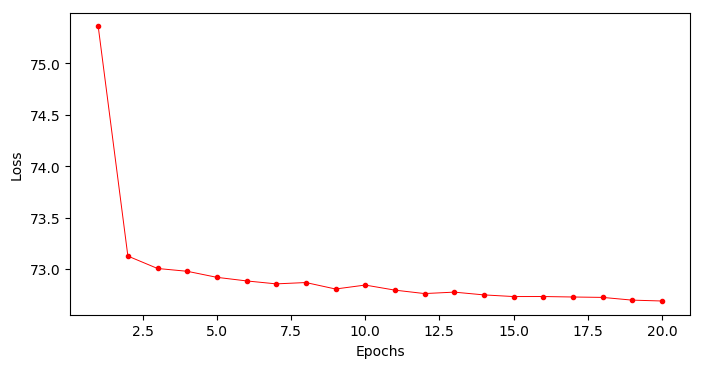

In [188]:
_ = plot_loss(EPOCHS, loss_hist)

# Model evaluation

In [48]:
tmax = 3600

MODEL_FILES = glob.glob("../saved_models/HawkesDec*.pth")
MODEL_FILES.sort()
for p in MODEL_FILES:
    print(p)

../saved_models/HawkesDecayRNN-2d_hidden128-20181209-153942.pth
../saved_models/HawkesDecayRNN-2d_hidden128-20181209-212603.pth
../saved_models/HawkesDecayRNN-2d_hidden128-20181210-013110.pth


In [49]:
load_filename = MODEL_FILES[0]
print("chosen file:", load_filename)

load_file_timestamp = "-".join(os.path.splitext(os.path.basename(load_filename))[0].split('-')[-2:])
print(load_file_timestamp)

chosen file: ../saved_models/HawkesDecayRNN-2d_hidden128-20181209-153942.pth
20181209-153942


In [50]:
from models.decayrnn import HawkesDecayRNN, HawkesRNNGen
process_dim = 2
hidden_size = 128
print("Hidden size: {}".format(hidden_size))
model = HawkesDecayRNN(process_dim, hidden_size)

model.load_state_dict(torch.load(load_filename, map_location={"cuda:0": "cpu"}))

Hidden size: 128


## Sequence generation

### Untrained model, random weights

In [48]:
print("Real end time: {}".format(tmax))

Real end time: 3600


In [10]:
raw_model = HawkesDecayRNN(process_dim, hidden_size)
generator_base = HawkesRNNGen(raw_model)

Process model dim:	2	Hidden units:	128


In [11]:
sum(e.numel() for e in raw_model.parameters())

33926

no. of events: 30
0: type 0
1: type 1


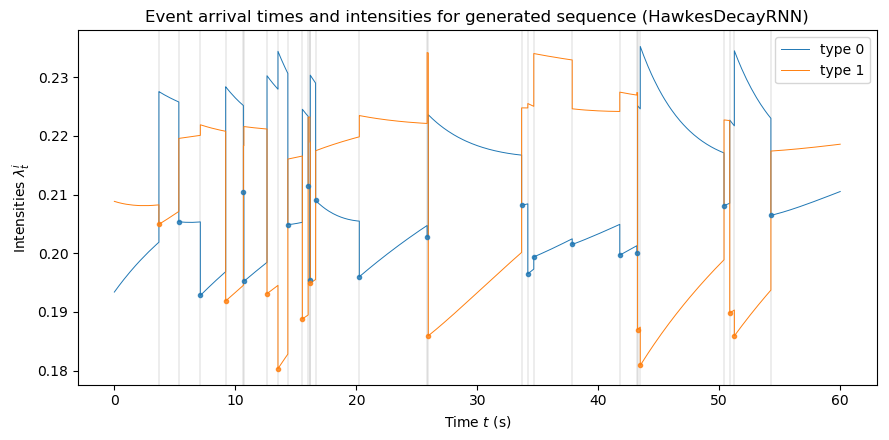

In [12]:
tmax_simu = 60
generator_base.generate_sequence(tmax_simu, record_intensity=True)

fig = generator_base.plot_events_and_intensity(debug=False)
fig.tight_layout()

In [52]:
fig.savefig("example_rnnplot2d_hidden{}.pdf".format(hidden_size))

### On trained model

In [51]:
RESULT_BASEDIR = "../results"

MODEL_NAME = model.__class__.__name__
print(MODEL_NAME)

HawkesDecayRNN


In [52]:
generator = HawkesRNNGen(model, record_intensity=False)

Process model dim:	2	Hidden units:	128


no. of events: 22
0: type 0
1: type 1


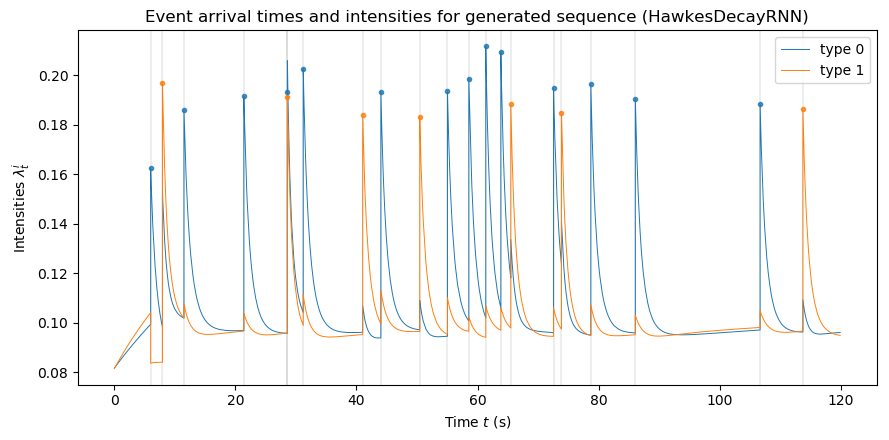

In [53]:
tmax_simu = 120
generator.generate_sequence(tmax_simu, record_intensity=True)
fig_intensity_stream = generator.plot_events_and_intensity()

In [17]:
fig_intensity_stream.savefig("../results/intensity_{}_{}d-sumexp_hidden{}_{}.pdf".format(
    MODEL_NAME, process_dim, hidden_size, load_file_timestamp))

## Length distribution

In [18]:
from utils import evaluation

In [19]:
n_gen_seq = 500

In [267]:
gen_seq_lengths, gen_seq_types_lengths = evaluation.generate_multiple_sequences(generator, tmax, n_gen_seq=500)

tmax: 1800
Mean generated sequence length: 768.29
Generated sequence length std. dev: 30.95942344424392


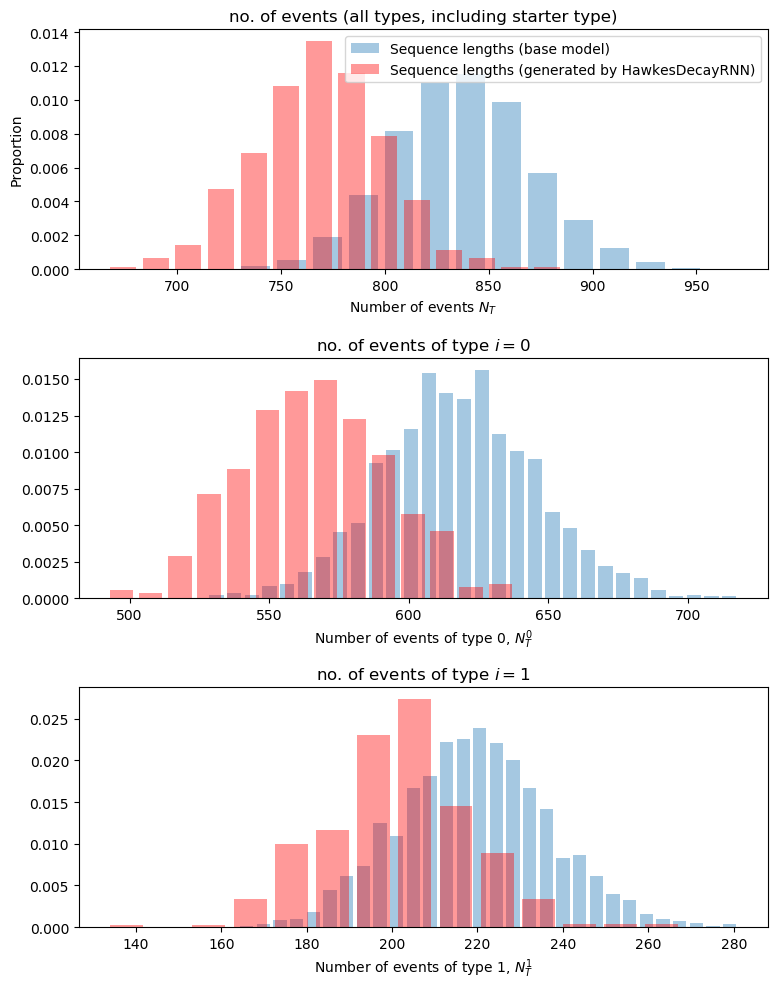

In [270]:
if process_dim > 1:
    num_plots = process_dim + 1
else:
    num_plots = 1
fig, axes = plt.subplots(num_plots, 1, figsize=(8,4+(num_plots-1)*3), dpi=100)
ax0 = axes[0] if num_plots > 1 else axes
hist_opts = {
    "rwidth": 0.8,
    "alpha": 0.4,
    "density": True
}
gen_label = "Sequence lengths (generated by {:})".format(MODEL_NAME)
_ = ax0.hist(seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label="Sequence lengths (base model)",
            **hist_opts)
_ = ax0.hist(gen_seq_lengths, bins=2*int(n_gen_seq**(1/3)),
            label=gen_label,
            color='red', **hist_opts)
ax0.legend()
if num_plots > 1:
    ax0.set_title('no. of events (all types, including starter type)')
else:
    ax0.set_title('no. of  events')
ax0.set_ylabel('Proportion')
ax0.set_xlabel('Number of events $N_T$')
if num_plots > 1:
    axt = axes[1:]
    for i, ax in enumerate(axt):
        # get the sequence lengths for the event types
        typ_seq_lengths = (seq_types == i).sum(dim=1)
        gen_typ_seq_lengths = gen_seq_types_lengths[:, i]
        ax.hist(typ_seq_lengths, bins=2*int(typ_seq_lengths.size(0)**(1/3)),
                label="Sequence lengths (base model)",
                **hist_opts)
        ax.hist(gen_typ_seq_lengths,
                bins=2*int(gen_typ_seq_lengths.shape[0]**(1/3)),
                label=gen_label,
                color='red', **hist_opts)
        ax.set_xlabel("Number of events of type {}, $N_T^{}$".format(i, i))
        ax.set_title('no. of events of type $i={}$'.format(i))

fig.tight_layout()

In [272]:
os.makedirs(RESULT_BASEDIR, exist_ok=True)
model_perf_indicator = "length_distrib"
distrib_plot_filepath = "{:}/{:}_{:}-{}-hidden_{}-{}.pdf".format(
    RESULT_BASEDIR, model_perf_indicator, MODEL_NAME,
    process_dim, model.hidden_size, load_file_timestamp)
fig.savefig(distrib_plot_filepath)

## Event prediction

The $L_2$-wise best estimator for the next event occurrence time is given by

$$
\begin{aligned}
    \hat{t}_i &= \mathbb{E}[t_i\mid\mathcal F_{t_{i-1}}] \\
    &= t_{i-1} + \int_0^\infty u p_i(u)\, du
\end{aligned}
$$

In [20]:
import tqdm
from utils import evaluation

In [54]:
dataset_size = seq_times.shape[0]
print(dataset_size)

4000


1467
last event: time 3585.153 type 1.000
next event: time 3596.930 type 0.000, in 11.778
sum of density: tensor(0.9901)
type probabilities: tensor([0.4489, 0.5266])
(tensor(4.5418), tensor(11.7778), tensor(52.3596), tensor(0), tensor(1))


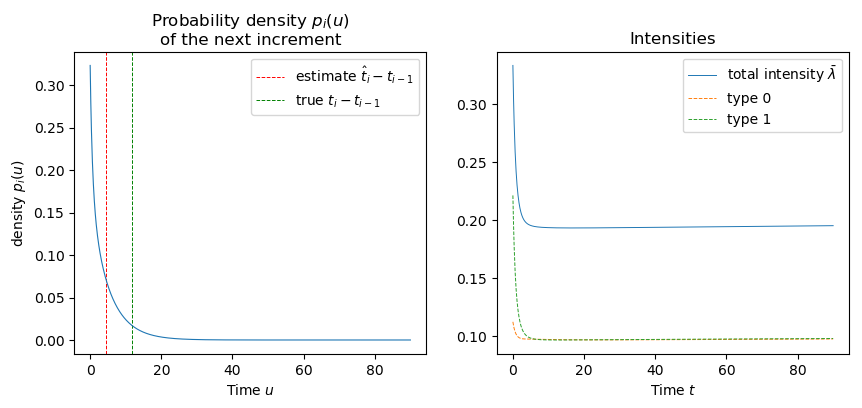

In [55]:
my_index = torch.randint(0, dataset_size, (1,)).int().item()
print(my_index)

_seq_data = (seq_times[my_index],
             seq_types[my_index],
             seq_lengths[my_index])

restup, fig = model.read_predict(*_seq_data, plot=True, hmax=90., print_info=True)
print(restup)

In [56]:
fig.savefig('decayrnn_{}d_prediction_graphs_hidden{}_NEW.pdf'
            .format(process_dim, hidden_size))

In [25]:
train_size = 1200
test_size = 1000

print("Train:", train_size)
print("Test:", test_size)

Train: 1200
Test: 1000


In [26]:
test_data = (seq_times[train_size:(train_size+test_size)],
             seq_types[train_size:(train_size+test_size)],
             seq_lengths[train_size:(train_size+test_size)])

In [27]:
incr_estimates, incr_errors, types_real, types_estimates = evaluation.predict_test(model, *test_data,
                                                                                   hmax=90., use_jupyter=True)

In [28]:
avg_rmse = np.sqrt(np.mean(incr_errors), dtype=np.float64)
print("rmse", avg_rmse)

mse_var = np.var(incr_errors, dtype=np.float64)
print("mse var", mse_var)

delta_meth_stderr = 1 / test_size * mse_var / (4 * avg_rmse)
print("rmse var", delta_meth_stderr)

rmse 3.7128522249871843
mse var 1464.2632804715774
rmse var 0.09859423374146217


In [29]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [30]:
types_predict_score = accuracy_score(types_real, types_estimates)
print("Type prediction score:", types_predict_score)

print("Confusion matrix:\n", confusion_matrix(types_real, types_estimates))

Type prediction score: 0.592
Confusion matrix:
 [[  0 403]
 [  5 592]]


In [31]:
sum(e.numel() for e in model.parameters())

33926

In [32]:
predict_data = {
    "model_name": MODEL_NAME,
    "process_dim": process_dim,
    "hidden_size": hidden_size,
    "data_file": chosen_data_file,
    "avg_rmse": avg_rmse,
    "var_mse": mse_var,
    "std_rmse": delta_meth_stderr,
    "pred_score": types_predict_score,
    "model_timestamp": load_file_timestamp,
    "train_size": train_size,
    "test_size": test_size
}

predict_data

{'model_name': 'HawkesDecayRNN',
 'process_dim': 2,
 'hidden_size': 128,
 'data_file': '../data/simulated/hawkes_sumxp_synthetic_exp_2d_20181210-002610.pkl',
 'avg_rmse': 3.7128522249871843,
 'var_mse': 1464.2632804715774,
 'std_rmse': 0.09859423374146217,
 'pred_score': 0.592,
 'model_timestamp': '20181210-013110',
 'train_size': 1200,
 'test_size': 1000}

In [33]:
load_file_timestamp

'20181210-013110'

In [34]:
import json

predict_res_file = "predict_results_{}d-sumexp.json".format(process_dim)

predict_data.keys()

with open(predict_res_file, "r+", encoding='utf-8', newline='\n') as fp:
    try:
        data = json.load(fp)
    except json.JSONDecodeError:
        data = []
    data.append(predict_data)
    fp.seek(0)
    json.dump(data, fp, indent=4)
    fp.write('\n')